In [1]:
import pandas as pd
import numpy as np
#from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
#import seaborn as sns
import openpyxl
from tensorflow.keras.layers import *
#from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout
#import matplotlib

# Approach #1: Using a MLP for the Prediction of EC, after we convert the dataset to Supervised. 

## Read the dataset 

In [2]:
data=pd.read_excel('hourly_data.xlsx',header=0)

In [3]:
data['Mean Conductivity per Hour']=data['Mean Conductivity per Hour'].round(decimals = 0)

In [4]:
#data=data.set_index('Date')

In [5]:
data

,Date,Atm.Temperature,Mean Watertemperature per Hour,Mean Salinity per Hour,Mean Conductivity per Hour,Mean Chlorofyl per Hour
0,2021-04-06 11:00:00,4.9,9.900000,0.473333,680.0,4.466667
1,2021-04-06 12:00:00,5.5,9.900000,0.470000,677.0,5.000000
2,2021-04-06 13:00:00,4.5,9.916667,0.475000,682.0,6.066667
3,2021-04-06 14:00:00,1.8,9.891667,0.475000,682.0,7.108333
4,2021-04-06 15:00:00,2.2,9.800000,0.477500,683.0,7.375000
...,...,...,...,...,...,...
8660,2022-04-02 20:00:00,1.4,10.200000,0.500000,723.0,10.233333
8661,2022-04-02 21:00:00,1.2,10.125000,0.498333,717.0,9.558333
8662,2022-04-02 22:00:00,0.9,10.100000,0.505833,727.0,9.908333
8663,2022-04-02 23:00:00,-0.2,10.075000,0.510000,735.0,9.791667


## Isolate Mean Conductivity per Hour which is the mean EC value recorded for each hour. 

In [6]:
only_mean_conductivity=data['Mean Conductivity per Hour'].to_frame(name='Mean Conductivity per Hour')

## Standarization using MinMax Scaler 

In [7]:
df= only_mean_conductivity.copy()
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled  = min_max_scaler.fit_transform(np.reshape(df['Mean Conductivity per Hour'].values, (df.shape[0], 1)))
df_scaled  = pd.DataFrame(data=df_scaled , columns=['Mean Conductivity per Hour'])

In [8]:
df_scaled.tail()

,Mean Conductivity per Hour
8660,0.629752
8661,0.619835
8662,0.636364
8663,0.649587
8664,0.659504


## Convert Dataframe to Supervised in order to be fitted in the model. 

In [9]:
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

## We are using an input step of 15. That means that our model will use the previous 15 values (hours )in order to predict the next one. 

In [10]:
n_in = 15 #Timeseries consists of 90 input steps.
n_out = 1
sdf = timeseries_to_supervised(df_scaled, n_in, n_out)

In [11]:
sdf.head()

,Mean Conductivity per Hour(t-15),Mean Conductivity per Hour(t-14),Mean Conductivity per Hour(t-13),Mean Conductivity per Hour(t-12),Mean Conductivity per Hour(t-11),Mean Conductivity per Hour(t-10),Mean Conductivity per Hour(t-9),Mean Conductivity per Hour(t-8),Mean Conductivity per Hour(t-7),Mean Conductivity per Hour(t-6),Mean Conductivity per Hour(t-5),Mean Conductivity per Hour(t-4),Mean Conductivity per Hour(t-3),Mean Conductivity per Hour(t-2),Mean Conductivity per Hour(t-1),Mean Conductivity per Hour(t)
15,0.558678,0.553719,0.561983,0.561983,0.563636,0.543802,0.550413,0.550413,0.553719,0.553719,0.558678,0.563636,0.537190,0.523967,0.532231,0.510744
16,0.553719,0.561983,0.561983,0.563636,0.543802,0.550413,0.550413,0.553719,0.553719,0.558678,0.563636,0.537190,0.523967,0.532231,0.510744,0.502479
17,0.561983,0.561983,0.563636,0.543802,0.550413,0.550413,0.553719,0.553719,0.558678,0.563636,0.537190,0.523967,0.532231,0.510744,0.502479,0.520661
18,0.561983,0.563636,0.543802,0.550413,0.550413,0.553719,0.553719,0.558678,0.563636,0.537190,0.523967,0.532231,0.510744,0.502479,0.520661,0.510744
19,0.563636,0.543802,0.550413,0.550413,0.553719,0.553719,0.558678,0.563636,0.537190,0.523967,0.532231,0.510744,0.502479,0.520661,0.510744,0.497521


In [12]:
X, y = sdf[[('Mean Conductivity per Hour(t-%d)' % i) for i in range(15, 0, -1)]].values, sdf['Mean Conductivity per Hour(t)'].values

## Seperate Dataset for Training and Testing 

In [13]:
len_data = X.shape[0]
print("Data size: %d" % len_data)
train_size = int(len_data * .7)# 70% for training and 30% for testing
print ("Train  data size: %d" % train_size)
print ("Test data size: %d" % (len_data - train_size))

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:]
test_dates=data[train_size:].iloc[15:].Date #Keep the dates of the test dataset for display purposes
print(xtr.shape, ytr.shape)
print(xte.shape, yte.shape)

Data size: 8650
Train  data size: 6055
Test data size: 2595
(6055, 15) (6055,)
(2595, 15) (2595,)


In [14]:
xte.shape

(2595, 15)

## Build the MLP Model 

In [15]:
batch_size = 1 #1
model = Sequential()

model.add(Dense(units=50, input_dim=xtr.shape[1], activation="relu"))#input dim is 4 as the timeseries steps.
model.add(Dense(50, activation="relu"))# linear activation functios was used as well
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                800       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________


## Time for training 

In [16]:
model.fit(xtr,ytr, epochs=10, batch_size=batch_size, verbose=2)

Epoch 1/10
6055/6055 - 2s - loss: 0.0058
Epoch 2/10
6055/6055 - 2s - loss: 0.0018
Epoch 3/10
6055/6055 - 2s - loss: 0.0013
Epoch 4/10
6055/6055 - 2s - loss: 0.0012
Epoch 5/10
6055/6055 - 2s - loss: 0.0012
Epoch 6/10
6055/6055 - 2s - loss: 0.0012
Epoch 7/10
6055/6055 - 2s - loss: 0.0012
Epoch 8/10
6055/6055 - 2s - loss: 0.0011
Epoch 9/10
6055/6055 - 2s - loss: 0.0011
Epoch 10/10
6055/6055 - 2s - loss: 0.0011


## Time for Testing 

In [17]:
#trainPredict = model.predict(xtr, batch_size=batch_size)
testPredict = model.predict(xte, batch_size=batch_size)

In [18]:
#ytr2d = np.reshape(ytr, (ytr.shape[0], 1))
yte2d = np.reshape(yte, (yte.shape[0], 1)) # reshape data

## Inverse Scaling in order to get the true predictions 

In [19]:
#trainPredict = min_max_scaler.inverse_transform(trainPredict)
#trainY = min_max_scaler.inverse_transform(ytr2d)
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform(yte2d)

## Evaluate using MSE, MAE and R2 

In [20]:
print("Test MSE: ", mean_squared_error(testY, testPredict))
print("Test MAE: ", sum(abs(testY-testPredict))/testY.shape[0])
print("Test R2: ", r2_score(testY, testPredict))

Test MSE:  108.1000322520277
Test MAE:  [7.99869734]
Test R2:  0.9868641638727512


## The model seems to do a pretty good job by the measures. Let's Display the testing phase in a plot in order to view it. 

## Preprocess in order to create the dataframe for the plot diagram.

In [21]:
predictions=pd.DataFrame(testPredict)
test_data=pd.DataFrame(testY)
test_dates=test_dates.reset_index(drop=True)
predictions=pd.concat((test_dates,predictions),axis=1)
predictions=predictions.rename(columns={0:'EC Predicted'})
predictions=pd.concat((predictions,test_data),axis=1)
predictions=predictions.rename(columns={0:'EC Original'})

In [22]:
predictions.tail()

,Date,EC Predicted,EC Original
2590,2022-04-02 20:00:00,718.070740,723.0
2591,2022-04-02 21:00:00,712.795776,717.0
2592,2022-04-02 22:00:00,710.097778,727.0
2593,2022-04-02 23:00:00,714.398926,735.0
2594,2022-04-03 00:00:00,722.114014,741.0


## Display in a Plot 

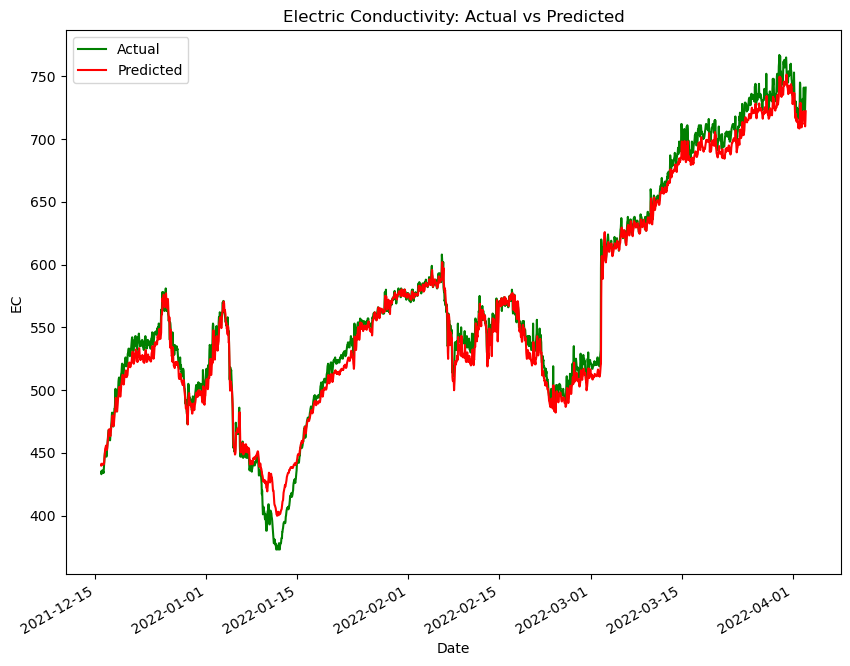

In [23]:

plt.figure(figsize=(10, 8))
plt.plot(predictions['Date'],predictions['EC Original'],label='Actual',color='green')
plt.plot(predictions['Date'],predictions['EC Predicted'],label='Predicted',color='red')
plt.title("Electric Conductivity: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("EC")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Forecast the next Hour 

### Create the dataset for the forecast. We keep the last fifteen values of our dataset and we forecast the next one, in our case next Hour

In [24]:
forecast=df_scaled[-15:]
forecast=forecast.to_numpy()
forecast=forecast.reshape(1,15)

In [25]:
#create date labels
n_past = 15
n_days_for_testing_prediction=16  #predict the next hour
predict_period_dates = pd.date_range(list(test_dates)[-n_past], periods=n_days_for_testing_prediction,freq='h').tolist()
predict_period_dates=predict_period_dates[-1:]

### The datetime the model will predict is the next hour from our known dataset 

In [26]:
predict_period_dates

[Timestamp('2022-04-03 01:00:00', freq='H')]

## Actual Forecast

In [27]:
forecast = model.predict(forecast, batch_size=batch_size)#predict

## Inverse Scaling 

In [28]:
forecast = min_max_scaler.inverse_transform(forecast)#inverse

In [29]:
forecast=np.squeeze(forecast)#reshape

In [30]:
#give the right Date labels
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Conductivity Forecasted':forecast})

### The forecasted values for the next hour is:

In [31]:
df_forecast

,Date,Mean Conductivity Forecasted
0,2022-04-03 01:00:00,728.587158


## Preprocess for demonstration purposes 

In [32]:
forecast=pd.concat([data.iloc[-15:].reset_index(),df_forecast])

In [33]:
forecast.tail()

,index,Date,Atm.Temperature,Mean Watertemperature per Hour,Mean Salinity per Hour,Mean Conductivity per Hour,Mean Chlorofyl per Hour,Mean Conductivity Forecasted
11,8661.0,2022-04-02 21:00:00,1.2,10.125,0.498333,717.0,9.558333,NaN
12,8662.0,2022-04-02 22:00:00,0.9,10.100,0.505833,727.0,9.908333,NaN
13,8663.0,2022-04-02 23:00:00,-0.2,10.075,0.510000,735.0,9.791667,NaN
14,8664.0,2022-04-03 00:00:00,-0.4,9.975,0.518333,741.0,9.483333,NaN
0,NaN,2022-04-03 01:00:00,NaN,NaN,NaN,NaN,NaN,728.587158


In [34]:
forecast['Date']=pd.to_datetime(forecast['Date'])

## The blue dot is the forecasted value of EC in the next unknown hour 

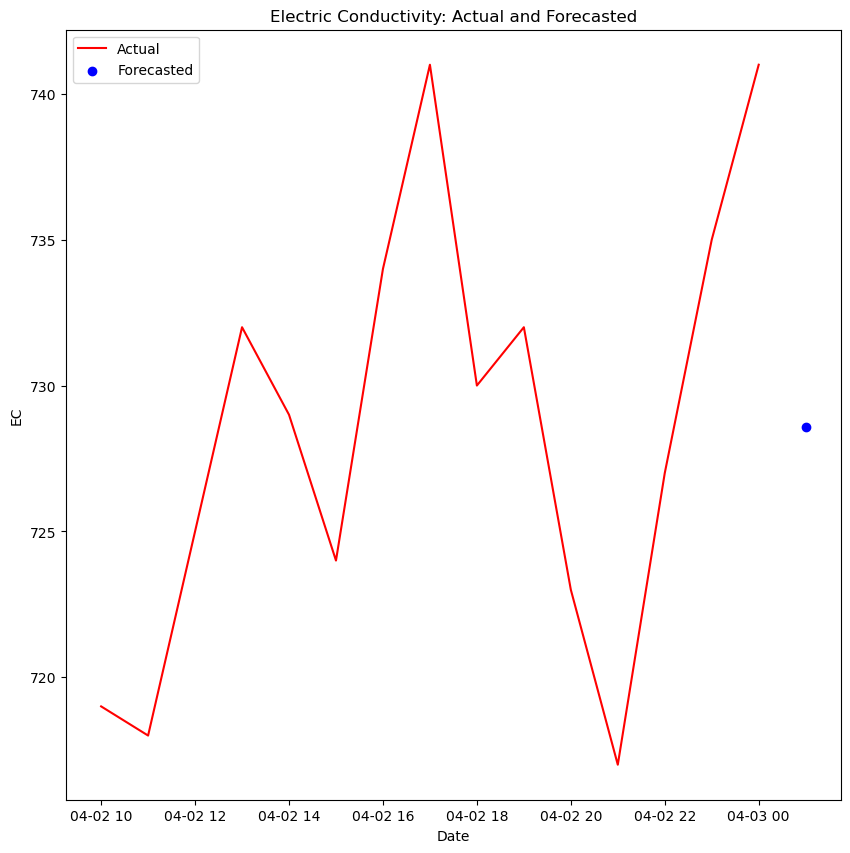

In [35]:

plt.figure(figsize=(10, 10))
plt.plot(forecast['Date'],forecast['Mean Conductivity per Hour'],label='Actual',color='red')
plt.scatter(forecast['Date'],forecast['Mean Conductivity Forecasted'],label='Forecasted',color='blue')
plt.title("Electric Conductivity: Actual and Forecasted")
plt.xlabel("Date")
plt.ylabel("EC")
plt.legend()
plt.show()

# Approach #2: Using a Multivariate LSTM ( RNN) model, which uses the values of the other 4 features to predict the Electrical Conductivity. 

In [36]:
df2_date=data[['Date']] # Keep the dates for display purposes

## Seperate Dataset to Training and Testing 

## Training 

In [37]:
df2_train=data.iloc[0:6000,1:] #training
df2_train_dates=df2_date.iloc[0:6000] #Testing Dates

In [38]:
df2_train_dates.shape

(6000, 1)

## Testing 

In [39]:
df2_test=data.iloc[6000:,1:]#training
df2_test_dates=df2_date.iloc[6000:] #training dates
df2_test.reset_index(inplace=True)

In [40]:
df2_test.shape

(2665, 6)

### Standarization using Standard Scaler this time 

In [41]:
sc=StandardScaler()
df2_train_scaled=sc.fit_transform(df2_train[['Atm.Temperature','Mean Watertemperature per Hour','Mean Salinity per Hour','Mean Chlorofyl per Hour']])

In [42]:
data

,Date,Atm.Temperature,Mean Watertemperature per Hour,Mean Salinity per Hour,Mean Conductivity per Hour,Mean Chlorofyl per Hour
0,2021-04-06 11:00:00,4.9,9.900000,0.473333,680.0,4.466667
1,2021-04-06 12:00:00,5.5,9.900000,0.470000,677.0,5.000000
2,2021-04-06 13:00:00,4.5,9.916667,0.475000,682.0,6.066667
3,2021-04-06 14:00:00,1.8,9.891667,0.475000,682.0,7.108333
4,2021-04-06 15:00:00,2.2,9.800000,0.477500,683.0,7.375000
...,...,...,...,...,...,...
8660,2022-04-02 20:00:00,1.4,10.200000,0.500000,723.0,10.233333
8661,2022-04-02 21:00:00,1.2,10.125000,0.498333,717.0,9.558333
8662,2022-04-02 22:00:00,0.9,10.100000,0.505833,727.0,9.908333
8663,2022-04-02 23:00:00,-0.2,10.075000,0.510000,735.0,9.791667


In [43]:
sc2=StandardScaler()
df2_train_scaled_y=sc2.fit_transform(df2_train[['Mean Conductivity per Hour']])# Y is our targer which is Mean Conductivity (EC)

In [44]:
df2_train_scaled_y.shape

(6000, 1)

## Reshape : Use previous 14teen to Predict the EC Value

In [45]:
hops=14
no_records=1000
#no_cols=4
X_train=[]
y_train=[]
for i in range(14,6000):
    X_train.append(df2_train_scaled[i-14:i])
    y_train.append(df2_train_scaled_y[i][0])
X_train,y_train=np.array(X_train),np.array(y_train)

In [46]:
y_train.shape

(5986,)

In [47]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

(5986, 14, 4)

## Build the Model

In [48]:
model4=Sequential()
model4.add(LSTM(units=50,return_sequences=True,input_shape=(14,4)))
model4.add(LSTM(units=50))
model4.add(Dense(1))
model4.compile(optimizer='adam',loss='mean_squared_error')

## Training time 

In [49]:
model4.fit(X_train_shape,y_train,epochs=100,batch_size=32)

Epoch 1/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0780
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0348
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0305
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0266
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0225
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0174
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0147
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0129
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0123
Epoch 10/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0139
Epoch 11/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0121
Epoch 12/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0117
Epoch 13/100


188/188 [==============================] - 1s 6ms/step - loss: 0.0068
Epoch 100/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0069


###  Keep the last fourteen values from our training dataset and get rid of them when reshaping. Its for reshaping purposes

In [50]:
df_train_last14=df2_train.iloc[-14:]
df_test_full=df2_test.drop(columns={'index'})
full_df=pd.concat((df_train_last14,df_test_full),axis=0)
full_df.shape

(2679, 5)

In [51]:
full_df=full_df.drop(columns={'Mean Conductivity per Hour'})
full_df=sc.transform(full_df)

## Reshaping 

In [52]:
hops=14
no_records=1000
no_cols=4
X_train_shape_pred=[]

for i in range(14,full_df.shape[0]):
    X_train_shape_pred.append(full_df[i-14:i])
X_train_shape_pred=np.array(X_train_shape_pred)

## Right shape 

In [53]:
X_train_shape_pred.shape

(2665, 14, 4)

## Time for Testing 

In [54]:
ytest=model4.predict(X_train_shape_pred)

## Inverse in order to get true predictions 

In [55]:
y_final_pred=sc2.inverse_transform(ytest)
y_final_pred

array([[407.4639 ],
       [409.31927],
       [411.53998],
       ...,
       [717.60016],
       [722.5242 ],
       [724.8624 ]], dtype=float32)

## Preprocess 

In [56]:
final_ec_pred=pd.DataFrame(y_final_pred)
final_ec_pred.columns=['final_ec_pred']
final_ec_pred.head()

,final_ec_pred
0,407.463898
1,409.319275
2,411.539978
3,415.130280
4,417.835938


In [57]:
fully_final=pd.concat((final_ec_pred,df2_test),axis=1)
fully_final=fully_final.drop(columns={'index'})
df2_test_dates=df2_test_dates.reset_index(drop=True)
final=pd.concat(([fully_final,df2_test_dates]),axis=1)

In [58]:
final

,final_ec_pred,Atm.Temperature,Mean Watertemperature per Hour,Mean Salinity per Hour,Mean Conductivity per Hour,Mean Chlorofyl per Hour,Date
0,407.463898,10.1,9.500,0.360000,403.0,7.450000,2021-12-12 23:00:00
1,409.319275,10.2,9.500,0.360000,404.0,7.725000,2021-12-13 00:00:00
2,411.539978,10.1,9.500,0.360000,406.0,7.575000,2021-12-13 01:00:00
3,415.130280,9.9,9.500,0.360000,403.0,8.108333,2021-12-13 02:00:00
4,417.835938,8.0,9.500,0.360000,403.0,8.116667,2021-12-13 03:00:00
...,...,...,...,...,...,...,...
2660,726.359680,1.4,10.200,0.500000,723.0,10.233333,2022-04-02 20:00:00
2661,720.555908,1.2,10.125,0.498333,717.0,9.558333,2022-04-02 21:00:00
2662,717.600159,0.9,10.100,0.505833,727.0,9.908333,2022-04-02 22:00:00
2663,722.524170,-0.2,10.075,0.510000,735.0,9.791667,2022-04-02 23:00:00


## Evaluate using R2 

In [59]:
print("Test R2: ", r2_score(fully_final['Mean Conductivity per Hour'], fully_final['final_ec_pred']))

Test R2:  0.8906357982305617


In [124]:
model4.save('lstm')

INFO:tensorflow:Assets written to: lstm\assets


## Plot Testing Phase 

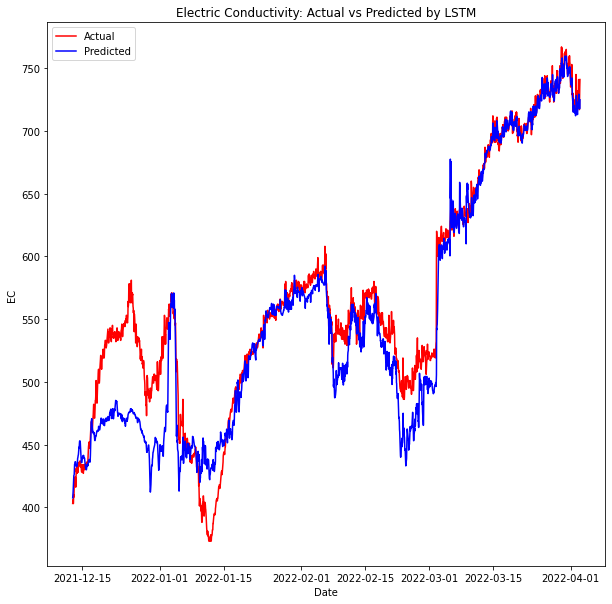

In [60]:
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(final['Date'],final['Mean Conductivity per Hour'],label='Actual',color='red')
plt.plot(final['Date'],final['final_ec_pred'],label='Predicted',color='blue')


plt.title("Electric Conductivity: Actual vs Predicted by LSTM")
plt.xlabel("Date")
plt.ylabel("EC")


plt.legend()
plt.show()

## Forecasting. The model will predict the value of the Electrical Conductivity for the next unknown hour given the values of the other four features.

In [61]:
dates =pd.to_datetime(df2_date['Date'].iloc[8664]) # get the final date

In [62]:
#Label the forecasted date
n_past = 0
n_days_for_prediction=2  #Predict the next 60 days using the previous 90

predict_period_dates = pd.date_range(dates, periods=n_days_for_prediction, freq='h').tolist()

In [63]:
predict_period_dates=pd.DataFrame(predict_period_dates)
predict_period_dates=predict_period_dates[-1:]
predict_period_dates.columns=['Date']
predict_period_dates=predict_period_dates.reset_index(drop=True)

In [83]:
for_forecast=df2_test[-14:]
for_forecast=for_forecast.drop(columns={'index'})
for_forecast=for_forecast.reset_index(drop=True)

## Read the forecasted by MLPs Values of the other four Features

In [84]:
new_values = pd.read_excel('forecasted_by_mlps.xlsx',header=0)

In [85]:
#new_values=new_values.rename(columns={'Atm.Temperature Forecasted':'Atm.Temperature','Mean Watertemperature per Hour Forecasted':'Mean Watertemperature per Hour','Salinity Forecasted':'Mean Salinity per Hour','Chlorofyl Forecasted':'Mean Chlorofyl per Hour'})

In [86]:
for_forecast=for_forecast.append(new_values,ignore_index=True)

In [102]:
for_forecast_dates=for_forecast[['Date']]
for_forecast_dates=for_forecast_dates.iloc[-14:]

In [89]:
for_forecast_scaled=sc.fit_transform(for_forecast[['Atm.Temperature','Mean Watertemperature per Hour','Mean Salinity per Hour','Mean Chlorofyl per Hour']])

In [70]:
#for_forecast.loc[28]

Atm.Temperature                              1.123779
Mean Watertemperature per Hour              10.033001
Mean Salinity per Hour                       0.502815
Mean Conductivity per Hour                        NaN
Mean Chlorofyl per Hour                     11.150275
Date                              2022-04-03 01:00:00
Name: 28, dtype: object

## Use the previous fourteen records and the new fourteen ones in order to keep the all the new ones after reshaping

### Reshaping 

In [91]:
hops=14
no_records=1000
no_cols=4
X_train_shape_pred=[]

for i in range(14,28):
    X_train_shape_pred.append(for_forecast_scaled[i-14:i])
X_train_shape_for=np.array(X_train_shape_pred)

In [92]:
X_train_shape_for.shape

(14, 14, 4)

### Make the forecast 

In [95]:
forecast=model4.predict(X_train_shape_for)

In [75]:
#forecast=forecast[len(forecast) - 1]

### Inverse Scaling 

In [98]:
forecast_final_pred=sc2.inverse_transform(forecast)


## Preprocess for demonstration 

In [134]:
forecast_final=pd.concat([for_forecast_dates.reset_index(drop=True),pd.DataFrame(forecast_final_pred)],axis=1)
forecast_final=forecast_final.rename(columns={0:'EC Forecasted'})
for_display=pd.concat((final.iloc[-50:],forecast_final))
for_display=for_display.reset_index(drop=True)


In [135]:
for_display.head()

,final_ec_pred,Atm.Temperature,Mean Watertemperature per Hour,Mean Salinity per Hour,Mean Conductivity per Hour,Mean Chlorofyl per Hour,Date,EC Forecasted
0,738.862610,1.9,11.800000,0.490000,735.0,10.441667,2022-03-31 23:00:00,NaN
1,736.773438,1.7,11.741667,0.492500,741.0,8.358333,2022-04-01 00:00:00,NaN
2,737.010864,1.1,11.700000,0.498333,745.0,9.466667,2022-04-01 01:00:00,NaN
3,741.652100,0.9,11.625000,0.499167,746.0,9.200000,2022-04-01 02:00:00,NaN
4,740.742371,0.6,11.558333,0.498333,745.0,9.783333,2022-04-01 03:00:00,NaN


## Plot the forecasted EC Value

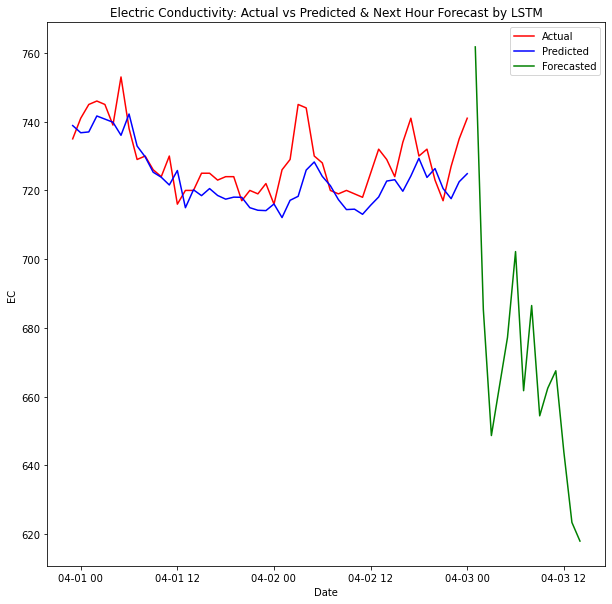

In [136]:

plt.figure(figsize=(10, 10))
plt.plot(for_display['Date'],for_display['Mean Conductivity per Hour'],label='Actual',color='red')
plt.plot(for_display['Date'],for_display['final_ec_pred'],label='Predicted',color='blue')
plt.plot(for_display['Date'],for_display['EC Forecasted'],label='Forecasted',color='green')
plt.title("Electric Conductivity: Actual vs Predicted & Next Hour Forecast by LSTM")
plt.xlabel("Date")
plt.ylabel("EC")
plt.legend()
plt.show()